In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import moyal

In [122]:
def get_tdc_spectra(file_path, xlim=None, ylim=None, normalize_y=False):
    data = np.loadtxt(file_path, delimiter="\t")
    x, y = data[:, 0], data[:, 1]
    if normalize_y:
        y = y / np.max(y)
        y_label = "Normalized Y-axis"
    else:
        y_label = "TDC counts"

    # Ask for plot title
    title_input = input("Enter the plot title (leave blank for no title): ")

    plt.figure()
    plt.plot(
        x,
        y,
        label="TDC Spectra",
        linestyle=":",
        color="steelblue",
        alpha=1.0,
        linewidth=1,
    )

    plt.xlabel("Channel")
    plt.ylabel(y_label)
    if title_input.strip():
        plt.title(title_input)

    plt.minorticks_on()
    plt.grid(which="both", linestyle="--", linewidth=0.5)

    plt.legend(loc="best", fontsize=9)

    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    plt.tight_layout()
    plt.show()
    return x, y

In [139]:
def analyze_tdc_spectrum(file_path, xlim=None, ylim=None, normalize_y=False):
    # Load the data
    data = np.loadtxt(file_path, delimiter="\t")
    x, y = data[:, 0], data[:, 1]

    # Normalize y if required
    if normalize_y:
        y = y / np.max(y)
        y_label = "Normalized Y-axis"
    else:
        y_label = "TDC counts"

    # Identify peaks
    from scipy.signal import find_peaks

    peaks, _ = find_peaks(
        y, height=np.max(y) * 0.1
    )  # Adjust height threshold as needed
    peak_positions = x[peaks]
    peak_heights = y[peaks]

    # Sort peaks by channel (ascending) and reverse delays
    sort_idx = np.argsort(peak_positions)
    peak_positions = peak_positions[sort_idx]
    peak_heights = peak_heights[sort_idx]

    # Plot the TDC spectrum with identified peaks
    plt.figure()
    plt.plot(x, y, label="TDC Spectrum", linestyle=":", color="steelblue", linewidth=1)
    plt.scatter(peak_positions, peak_heights, color="red", label="Peaks")
    plt.xlabel("Channel No.")
    plt.ylabel(y_label)
    plt.title("TDC Spectrum with Identified Peaks")
    plt.legend()
    plt.grid(which="both", linestyle="--", linewidth=0.5)
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    plt.tight_layout()
    plt.show()

    # Use reversed time delays
    time_delays = [16, 12, 8, 4, 0]
    if len(peak_positions) != len(time_delays):
        print("Number of peaks found does not match number of time delays!")
        return

    # Linear fit
    from scipy.optimize import curve_fit

    def linear_func(channel, slope, intercept):
        return slope * channel + intercept

    popt, pcov = curve_fit(linear_func, peak_positions, time_delays)
    slope, intercept = popt
    print(f"Linear Fit: Time (ns) = {slope:.4f} * Channel + {intercept:.4f}")

    # Plot channel vs time with linear fit
    plt.figure()
    plt.scatter(peak_positions, time_delays, color="blue", label="Data Points")
    if xlim is not None:
        fit_x = np.linspace(xlim[0], xlim[1], 500)
        plt.xlim(xlim)
    else:
        fit_x = np.linspace(np.min(x), np.max(x), 500)
    plt.plot(
        fit_x,
        linear_func(fit_x, *popt),
        color="red",
        linestyle="--",
        label=f"Linear Fit: Time = {slope:.4f} * Channel + {intercept:.4f}",
    )
    plt.xlabel("Channel No.")
    plt.ylabel("Time (ns)")
    plt.title("Channel vs Time with Linear Fit")
    plt.legend()
    plt.grid(which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

    return peak_positions, time_delays, slope, intercept

In [117]:
def get_adc_spectra(file_path, xlim=None, ylim=None, FWHM=False, normalize_y=False):
    data = np.loadtxt(file_path, delimiter="\t")
    x, y = data[:, 0], data[:, 1]
    if normalize_y:
        y = y / np.max(y)
        y_label = "Normalized Y-axis"
    else:
        y_label = "ADC counts"

    # Ask for plot title
    title_input = input("Enter the plot title (leave blank for no title): ")

    user_input = input(
        "Enter the x range for the fit as 'min,max' (leave blank to skip fit): "
    )
    fit_done = False
    fit_label = "Moyal Fit (on selected range)"
    FWHM_val = None
    fwhm_x1, fwhm_x2, half_max = None, None, None

    if user_input:
        try:
            x_min, x_max = map(float, user_input.split(","))
            mask = (x >= x_min) & (x <= x_max)
            x_fit, y_fit = x[mask], y[mask]

            if len(x_fit) == 0:
                print("No data in the specified range. Skipping fit.")
            else:

                def moyal_func(x, mu, sigma, amplitude):
                    return amplitude * moyal.pdf(x, mu, sigma)

                initial_mu = x_fit[np.argmax(y_fit)]
                initial_sigma = np.std(x_fit) / 2
                initial_amplitude = np.max(
                    y_fit
                )  # Use actual (not normalized) amplitude

                bounds = ([x_fit.min(), 0, 0], [x_fit.max(), np.inf, np.inf])

                popt, pcov = curve_fit(
                    moyal_func,
                    x_fit,
                    y_fit,
                    p0=[initial_mu, initial_sigma, initial_amplitude],
                    bounds=bounds,
                )

                mu, sigma, amplitude = popt

                print("Moyal Fit Parameters:")
                print(f"Mu (Location): {mu}")
                print(f"Sigma (Scale): {sigma}")
                print(f"Amplitude: {amplitude}")

                if FWHM:
                    x_fine = np.linspace(min(x_fit), max(x_fit), 5000)
                    y_fine = moyal_func(x_fine, *popt)
                    half_max = np.max(y_fine) / 2
                    above_half = np.where(y_fine >= half_max)[0]
                    if len(above_half) > 1:
                        fwhm_x1 = x_fine[above_half[0]]
                        r_idx = above_half[-1]
                        if r_idx + 1 < len(x_fine):
                            x_right_l = x_fine[r_idx]
                            x_right_r = x_fine[r_idx + 1]
                            y_right_l = y_fine[r_idx]
                            y_right_r = y_fine[r_idx + 1]
                            fwhm_x2 = x_right_l + (half_max - y_right_l) * (
                                x_right_r - x_right_l
                            ) / (y_right_r - y_right_l)
                        else:
                            fwhm_x2 = x_fine[r_idx]
                        FWHM_val = fwhm_x2 - fwhm_x1
                        print(f"FWHM: {FWHM_val}")
                        print(f"Right FWHM intersection at x = {fwhm_x2:.4f}")
                    else:
                        print("Could not determine FWHM.")

                fit_label = (
                    f"Moyal Fit (on selected range)\n"
                    f"$\\mu$ = {mu:.2f}\n"
                    f"$\\sigma$ = {sigma:.2f}\n"
                    f"Amplitude = {amplitude:.2f}"
                )
                if FWHM and FWHM_val is not None:
                    fit_label += f"\nFWHM = {FWHM_val:.2f}"

                fit_done = True
        except ValueError:
            print("Invalid input. Skipping fit.")

    plt.figure()
    plt.plot(
        x,
        y,
        label="ADC Spectra",
        linestyle=":",
        color="steelblue",
        alpha=1.0,
        linewidth=1,
    )
    if fit_done:
        plt.plot(
            x_fit,
            moyal_func(x_fit, *popt),
            color="red",
            label=fit_label,
            linewidth=1.75,
        )
        if (
            FWHM
            and FWHM_val is not None
            and fwhm_x1 is not None
            and fwhm_x2 is not None
        ):
            plt.hlines(
                half_max,
                fwhm_x1,
                fwhm_x2,
                color="green",
                linestyle="dotted",
                linewidth=2,
                label="FWHM",
            )
            plt.vlines(
                [fwhm_x1, fwhm_x2],
                0,
                half_max,
                color="green",
                linestyle="dotted",
                linewidth=1,
            )
            plt.scatter(fwhm_x2, half_max, color="green", zorder=5)
            plt.annotate(
                f"Edge = {fwhm_x2:.2f}",
                (fwhm_x2, half_max),
                textcoords="offset points",
                xytext=(15, 5),
                ha="left",
                color="green",
                fontsize=9,
                arrowprops=dict(arrowstyle="->", color="green"),
            )

    plt.xlabel("Channel")
    plt.ylabel(y_label)
    if title_input.strip():
        plt.title(title_input)

    plt.minorticks_on()
    plt.grid(which="both", linestyle="--", linewidth=0.5)

    plt.legend(loc="best", fontsize=9)

    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    plt.tight_layout()
    plt.show()
    return x, y

Moyal Fit Parameters:
Mu (Location): 286.27073344304125
Sigma (Scale): 21.286330391772985
Amplitude: 7803.62416465307
FWHM: 76.4069384965826
Right FWHM intersection at x = 334.8986


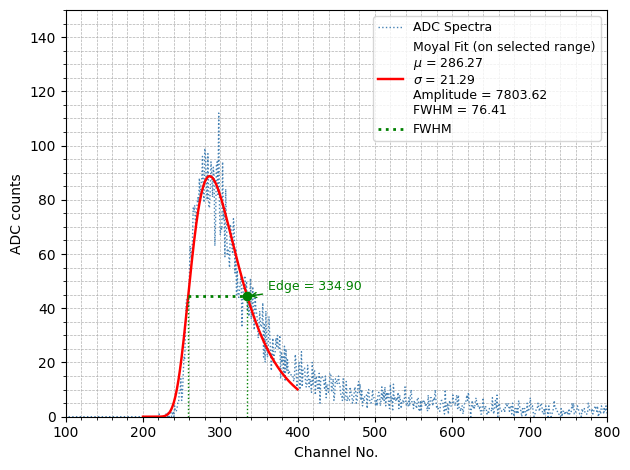

(array([1.000e+00, 2.000e+00, 3.000e+00, ..., 1.137e+03, 1.138e+03,
        1.139e+03]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [110]:
get_adc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.3/light-on/free_spectra_lightON_chA_adc_a.txt",
    xlim=(100, 800),
    ylim=(0, 150),
    FWHM=True,
)

Moyal Fit Parameters:
Mu (Location): 288.2842736153144
Sigma (Scale): 22.590516989231542
Amplitude: 7654.24373547823
FWHM: 81.07978815033835
Right FWHM intersection at x = 339.8916


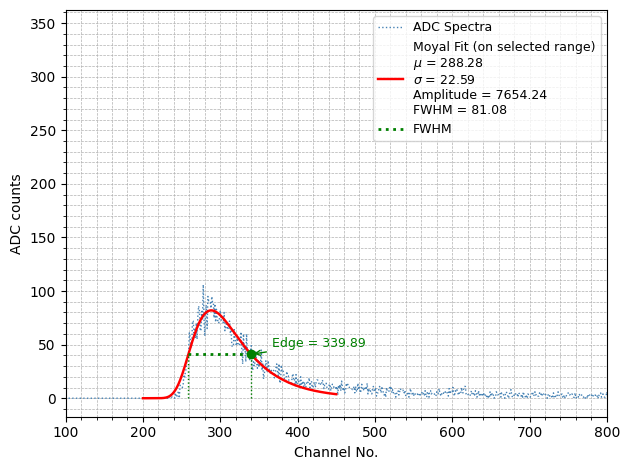

(array([1.000e+00, 2.000e+00, 3.000e+00, ..., 1.137e+03, 1.138e+03,
        1.139e+03]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [108]:
get_adc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.3/light-off/free_spectra_lightOFF_chA_adc_a.txt",
    xlim=(100, 800),
    # ylim=(0, 0.45),
    FWHM=True,
    normalize_y=False,
)

## Section 5.1.4


### Time Calibration


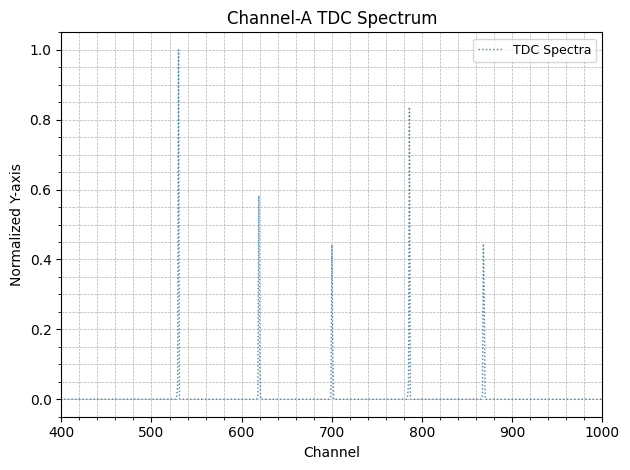

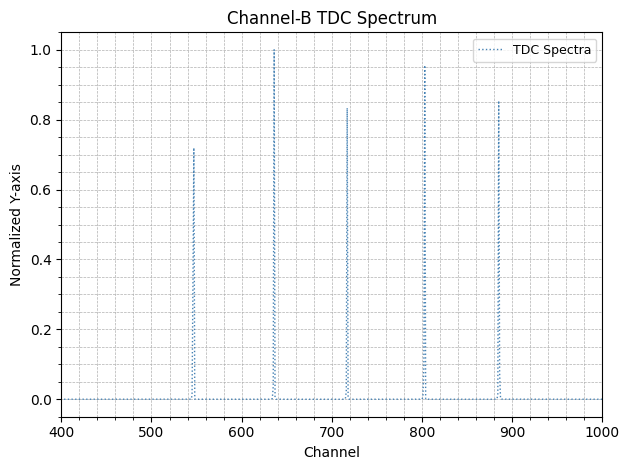

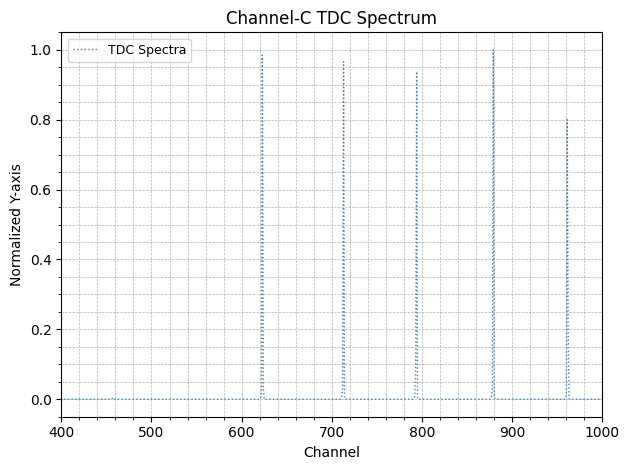

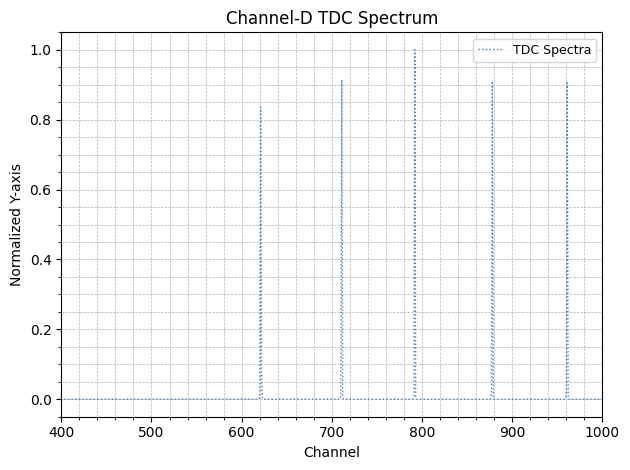

(array([1.000e+00, 2.000e+00, 3.000e+00, ..., 4.093e+03, 4.094e+03,
        4.095e+03]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [126]:
get_tdc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chA_tdc_a.txt",
    xlim=(400, 1000),
    normalize_y=True,
)
get_tdc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chB_tdc_b.txt",
    xlim=(400, 1000),
    normalize_y=True,
)
get_tdc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chC_tdc_c.txt",
    xlim=(400, 1000),
    normalize_y=True,
)
get_tdc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chD_tdc_d.txt",
    xlim=(400, 1000),
    normalize_y=True,
)

In [134]:
def analyze_tdc_spectrum(file_path, xlim=None, ylim=None, normalize_y=False):
    # Load the data
    data = np.loadtxt(file_path, delimiter="\t")
    x, y = data[:, 0], data[:, 1]

    # Normalize y if required
    if normalize_y:
        y = y / np.max(y)
        y_label = "Normalized Y-axis"
    else:
        y_label = "TDC counts"

    # Identify peaks
    from scipy.signal import find_peaks

    peaks, _ = find_peaks(
        y, height=np.max(y) * 0.1
    )  # Adjust height threshold as needed
    peak_positions = x[peaks]
    peak_heights = y[peaks]

    # Sort peaks by channel (ascending) and reverse delays
    sort_idx = np.argsort(peak_positions)
    peak_positions = peak_positions[sort_idx]
    peak_heights = peak_heights[sort_idx]

    # Plot the TDC spectrum with identified peaks
    plt.figure()
    plt.plot(x, y, label="TDC Spectrum", linestyle=":", color="steelblue", linewidth=1)
    plt.scatter(peak_positions, peak_heights, color="red", label="Peaks")
    plt.xlabel("Channel No.")
    plt.ylabel(y_label)
    plt.title("TDC Spectrum with Identified Peaks")
    plt.legend()
    plt.grid(which="both", linestyle="--", linewidth=0.5)
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    plt.tight_layout()
    plt.show()

    # Use reversed time delays
    time_delays = [16, 12, 8, 4, 0]
    if len(peak_positions) != len(time_delays):
        print("Number of peaks found does not match number of time delays!")
        return

    # Linear fit
    from scipy.optimize import curve_fit

    def linear_func(channel, slope, intercept):
        return slope * channel + intercept

    popt, pcov = curve_fit(linear_func, peak_positions, time_delays)
    slope, intercept = popt
    print(f"Linear Fit: Time (ns) = {slope:.4f} * Channel + {intercept:.4f}")

    # Plot channel vs time with linear fit
    plt.figure()
    plt.scatter(peak_positions, time_delays, color="blue", label="Data Points")
    if xlim is not None:
        fit_x = np.linspace(xlim[0], xlim[1], 500)
        plt.xlim(xlim)
    else:
        fit_x = np.linspace(np.min(x), np.max(x), 500)
    plt.plot(
        fit_x,
        linear_func(fit_x, *popt),
        color="red",
        linestyle="--",
        label=f"Linear Fit: Time = {slope:.4f} * Channel + {intercept:.4f}",
    )
    plt.xlabel("Channel No.")
    plt.ylabel("Time (ns)")
    plt.title("Channel vs Time with Linear Fit")
    plt.legend()
    plt.grid(which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

    return peak_positions, time_delays, slope, intercept

#### Channel-A PMT-A


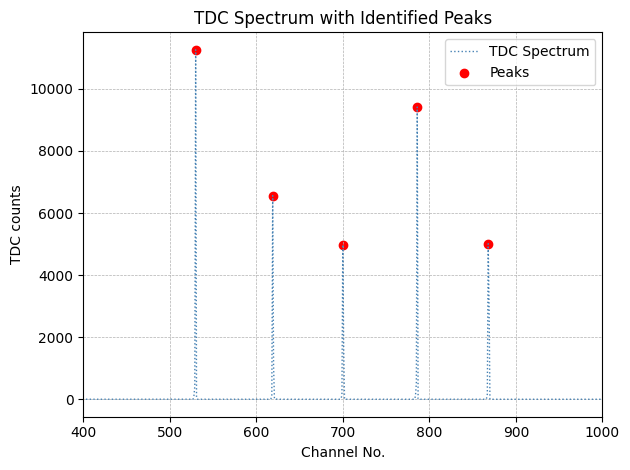

Linear Fit: Time (ns) = -0.0474 * Channel + 41.2365


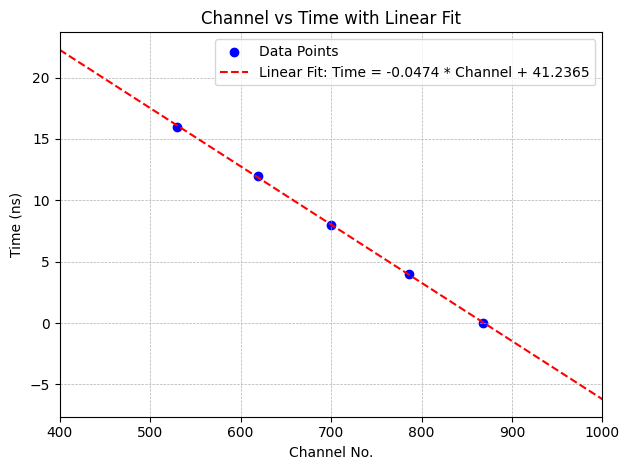

(array([530., 619., 700., 786., 868.]),
 [16, 12, 8, 4, 0],
 -0.04744003871492179,
 41.236491123674206)

In [135]:
analyze_tdc_spectrum(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chA_tdc_a.txt",
    xlim=(400, 1000),
)

#### Channel-B PMT-B


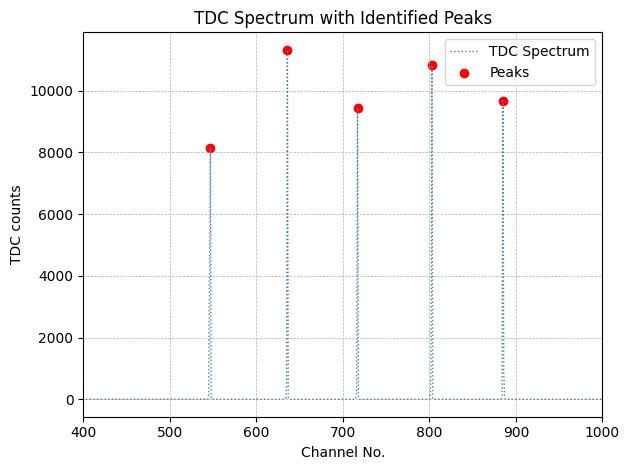

Linear Fit: Time (ns) = -0.0474 * Channel + 42.0430


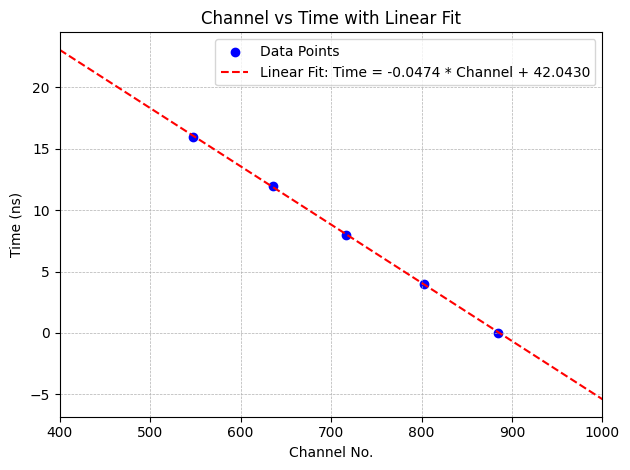

(array([547., 636., 717., 803., 885.]),
 [16, 12, 8, 4, 0],
 -0.04744003871965852,
 42.042971783677125)

In [136]:
analyze_tdc_spectrum(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chB_tdc_b.txt",
    xlim=(400, 1000),
)

#### Channel-C PMT-C


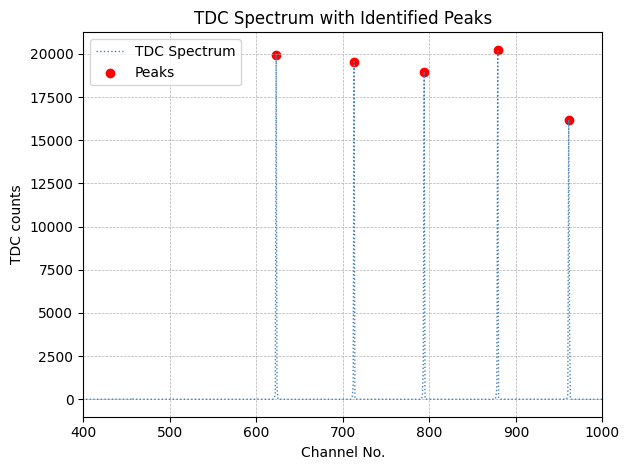

Linear Fit: Time (ns) = -0.0475 * Channel + 45.7093


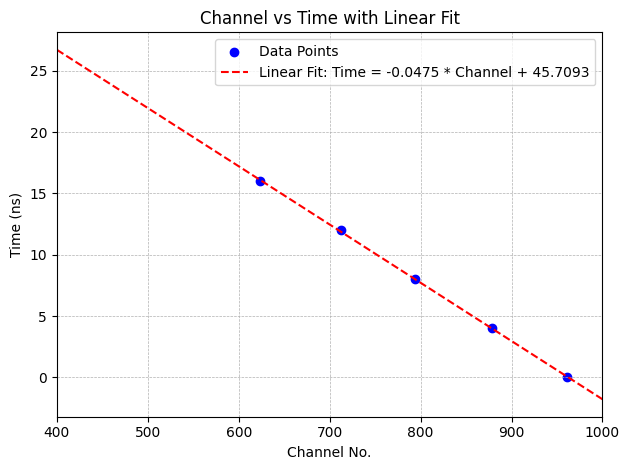

(array([623., 713., 794., 879., 961.]),
 [16, 12, 8, 4, 0],
 -0.04749280839421825,
 45.709289865009296)

In [137]:
analyze_tdc_spectrum(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chC_tdc_c.txt",
    xlim=(400, 1000),
)

#### Channel-D PMT-D


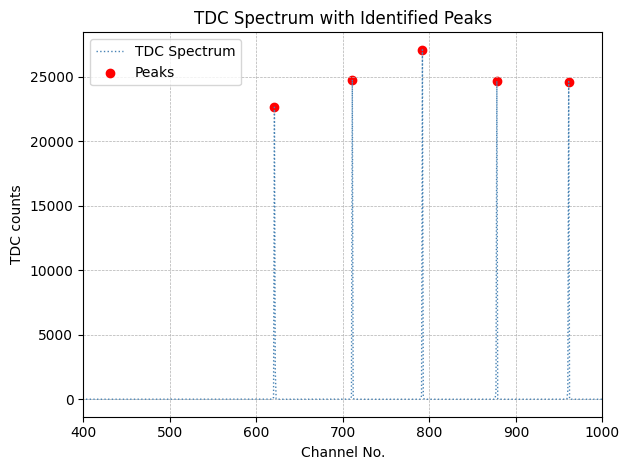

Linear Fit: Time (ns) = -0.0472 * Channel + 45.4224


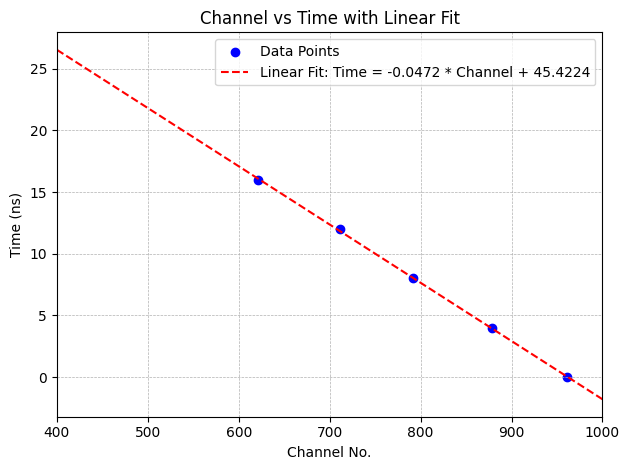

(array([621., 711., 792., 878., 961.]),
 [16, 12, 8, 4, 0],
 -0.04721477426883891,
 45.4224300837682)

In [138]:
analyze_tdc_spectrum(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chD_tdc_d.txt",
    xlim=(400, 1000),
)

#### Time calibration linear fit functions of Channel A,B,C,D respectively:

A- Linear Fit: Time (ns) = -0.0474 _ Channel + 41.2365  
B- Linear Fit: Time (ns) = -0.0474 _ Channel + 42.0430  
C- Linear Fit: Time (ns) = -0.0475 _ Channel + 45.7093  
D- Linear Fit: Time (ns) = -0.0472 _ Channel + 45.4224


### Energy Calibration
